## Imports

In [17]:
# ! pip install kornia

In [1]:
from tqdm import tqdm
import os
from pathlib import Path
import time
import pickle
import gc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

from data_loader import load_data, get_balanced_data, normalize_features

import seaborn as sns
import matplotlib.pyplot as plt
# import wandb
# wandb.init(project='gene')

/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import kornia
# from kornia.losses import FocalLoss

## Session parameters

In [3]:
!python -V

Python 3.10.15


In [4]:
print(torch.__version__), print(np.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

1.12.1
1.26.4
True
11.3


In [5]:
print(torch.cuda.current_device(), torch.cuda.device_count(), torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
print(device)

0 1 NVIDIA A40
cuda:0


## Loading Data

In [6]:
_ct = "DG_Glut"
_testing_type = "imbalanced"
# FEATURE_TYPES = 

In [7]:
data = load_data(y_val = "DEG", ct=_ct)

# For balanced testing (Regular Cross Entropy Loss)
if _testing_type == "balanced":
    X_balanced, y_balanced = get_balanced_data(data, method='balanced', y_val="DEG")
    
# For imbalanced training (loss function must accomodate for this)
elif _testing_type == "imbalanced":
    X_balanced = data['X']
    y_balanced = data['y']
else: 
    raise("error")

FEATURE_TYPES = ['mcg', 'atac', 'hic', 'genebody']
for k, v in X_balanced.items():
        print(k, len(v))

Processed mcg data
Processed genebody data
Processed atac data
Processed hic data
mcg 8310
genebody 8310
atac 8310
hic 8310


In [8]:
for _feat in FEATURE_TYPES:
    Path(f"../baseline_results/{_ct}/{_feat}").mkdir(parents=True, exist_ok=True)

In [9]:
y = data['y']
np.unique(y, return_counts=True)

(array([-1,  0,  1]), array([2659, 5461,  190]))

In [10]:
X_mcg = data['X']['mcg']
all0 = X_mcg[0][0]
count = {-1 : 0, 0 : 0, 1 : 0}
for x, yy in zip(X_mcg, y): 
    if all0 == x[0]: 
        count[yy]+=1
print(f"all 0 mcg entires:")
print(f"Down Reg: {count[-1]} / {(np.asarray(y) == -1).sum()}")
print(f"No Effect: {count[0]} / {(np.asarray(y) == 0).sum()}")
print(f"Up Reg: {count[1]} / {(np.asarray(y) == 1).sum()}")

all 0 mcg entires:
Down Reg: 2090 / 2659
No Effect: 4218 / 5461
Up Reg: 112 / 190


In [11]:
X_atac = data['X']['atac']
all0 = [0]*11
count = {-1 : 0, 0 : 0, 1 : 0}
for x, yy in zip(X_atac, y): 
    for xx in x: 
        if all0 == xx: 
            count[yy]+=1
print(f"all 0 atac entires:")
print(f"Down Reg: {count[-1]} / {(np.asarray(y) == -1).sum()}")
print(f"No Effect: {count[0]} / {(np.asarray(y) == 0).sum()}")
print(f"Up Reg: {count[1]} / {(np.asarray(y) == 1).sum()}")

all 0 atac entires:
Down Reg: 66 / 2659
No Effect: 158 / 5461
Up Reg: 5 / 190


In [12]:
X_hic = data['X']['hic']
all0 = [0]*len(X_hic[0][0])
count = {-1 : 0, 0 : 0, 1 : 0}
for x, yy in zip(X_hic, y): 
    for xx in x: 
        if all0 == xx: 
            count[yy]+=1
print(f"all 0 hic entires:")
print(f"Down Reg: {count[-1]} / {(np.asarray(y) == -1).sum()}")
print(f"No Effect: {count[0]} / {(np.asarray(y) == 0).sum()}")
print(f"Up Reg: {count[1]} / {(np.asarray(y) == 1).sum()}")

all 0 hic entires:
Down Reg: 554 / 2659
No Effect: 1102 / 5461
Up Reg: 27 / 190


In [13]:
X_gb = data['X']['genebody']
all0 = [0]*len(X_gb[0][0])
count = {-1 : 0, 0 : 0, 1 : 0}
for x, yy in zip(X_gb, y): 
    for xx in x: 
        if all0 == xx: 
            count[yy]+=1
print(f"all 0 genebody entires:")
print(f"Down Reg: {count[-1]} / {(np.asarray(y) == -1).sum()}")
print(f"No Effect: {count[0]} / {(np.asarray(y) == 0).sum()}")
print(f"Up Reg: {count[1]} / {(np.asarray(y) == 1).sum()}")

all 0 genebody entires:
Down Reg: 18 / 2659
No Effect: 8 / 5461
Up Reg: 1 / 190


In [14]:
sizes_mcg = []
sizes_atac = []
sizes_hic = []
sizes_gb = []
for i in range(len(y)):
    sizes_mcg.append(len(X_mcg[i]))
    sizes_atac.append(len(X_atac[i]))
    sizes_hic.append(len(X_hic[i]))
    sizes_gb.append(len(X_gb[i]))

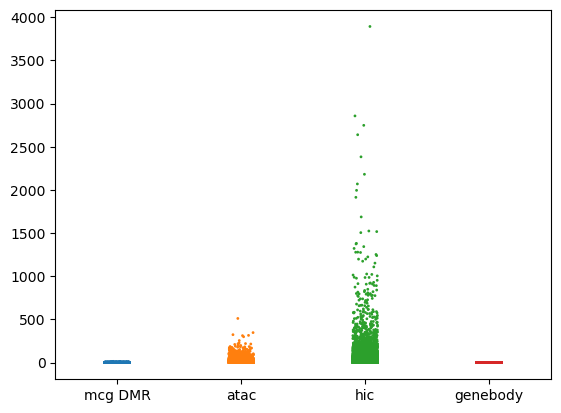

In [15]:
df_sizes = pd.DataFrame([sizes_mcg, sizes_atac, sizes_hic, sizes_gb], index=['mcg DMR', 'atac', 'hic', 'genebody']).T
sns.stripplot(df_sizes, s=2)
plt.show()

## Functions for handling the model

In [16]:
HIDDEN_DIM = 64
NUM_LAYERS = 4
NUM_HEADS = 8
DROPOUT = 0.1
LR = 1e-4
OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
NUM_EPOCHS = 50
BATCH_SIZE = 32

class OneHeadTransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, num_heads=1, dropout=0.1):
        super(OneHeadTransformerModel, self).__init__()
        self.cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.input_embedding = nn.Linear(input_dim, hidden_dim)

        # TODO: may need to use tanh in attention instead of softmax
        encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim*4, dropout=dropout, batch_first=True, norm_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # Use self-attention mechanism to combine the outputs of the four heads
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, _x, x_mask):
        # print('x in', _x.device)
        # print('x mask', x_mask.device)
        _x = self.input_embedding(_x)
        # print('x 1', _x.device)
        

        # Add cls embedding, so that we can take the first output as the representation of the sequence
        _cls_embedding = self.cls_embedding.repeat(_x.size(0), 1, 1)
        # print('cls', _cls_embedding.device)

        _z = torch.cat((_cls_embedding, _x), dim=1)
        # print('z 1', _z.device)

        _mask = torch.cat((torch.ones(x_mask.size(0), 1).to(device), x_mask), dim=1)
        # print('mask cat', _mask.device)

        _z = self.transformer(_z, src_key_padding_mask=~_mask.bool())
        # print('z 2', _z.device)
        
        # Pooling, we should not use average pooling since the sequence length is also important
        _z = _z[:, 0, :]
        # print('z 3', _z.device)
    
        # Combine the output of four heads into a sequence
        _z = _z.squeeze(-1) # (batch_size, hidden_dim, 1)
        # print('z 4', _z.device)
        output = self.classifier(_z)
        # print('out', output.device)

        del _x, x_mask, _cls_embedding, _mask, _z
        
        return output

In [17]:
# Dataset Object
class GeneDataset(Dataset):
    def __init__(self, _data, labels):
        self.data = _data
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        gene_data = torch.FloatTensor(self.data[idx]).to(device)
        label = torch.LongTensor([self.labels[idx] + 1]).to(device)  # Add 1 to shift labels to 0, 1, 2
        mask = torch.ones(len(gene_data)).to(device)
        return gene_data, label, mask

## handling the batches 
def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    gene_sequences, labels, masks, = zip(*batch)
    
    lengths = [len(seq) for seq in gene_sequences]
    max_len = max(lengths)
    
    padded_seqs = torch.zeros(len(gene_sequences), max_len, gene_sequences[0].size(1))
    padded_masks = torch.zeros(len(gene_sequences), max_len)
    
    for i, (seq, length) in enumerate(zip(gene_sequences, lengths)):
        padded_seqs[i, :length] = seq
        padded_masks[i, :length] = 1 
        
    return padded_seqs.to(device), torch.cat(labels), padded_masks.to(device)

In [18]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def checkpoint(model, fname):
    torch.save(model.state_dict(), fname)
    
def load_chkpt(model, fname):
    model.load_state_dict(torch.load(fname))
        
def train_model(X_train, y_train, X_test, y_test, exp_name, fold_idx):
    #wandb.init(project='gene', group=exp_name, name=f'fold-{fold_idx}')
    input_dim = len(X_train[0][0])
    
    train_dataset = GeneDataset(X_train, y_train)
    test_dataset = GeneDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = OneHeadTransformerModel(input_dim, HIDDEN_DIM, OUTPUT_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT).to(device)

    # For imbalanced CEL
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights.astype(np.float32)).to(device)
    # weights = torch.tensor(np.unique(y_train, return_counts=True)[1], dtype=float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    # criterion = FocalLoss(gamma=2, alpha=0.1)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0.0001)
    # Create the OneCycleLR scheduler
    # lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, total_steps=NUM_EPOCHS,
    #                           pct_start=0.8, anneal_strategy='cos',
    #                           cycle_momentum=False, div_factor=5.0,
    #                           final_div_factor=10.0)

    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    early_stopper = EarlyStopper(patience=5, min_delta=0.1)
    for epoch in range(NUM_EPOCHS):
        checkpoint(model, f"../logging/m_chkpt_{epoch}")
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0
        for x1, batch_y, mask1 in train_loader:
            optimizer.zero_grad()
            outputs = model(x1, mask1)
            loss = criterion(outputs, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == batch_y.squeeze()).sum().item()
            train_total += batch_y.size(0)
            del x1, batch_y, mask1, loss, outputs
        lr_scheduler.step()

        model.eval()
        correct = 0
        total = 0
        test_loss = 0
        with torch.no_grad():
            for x1, batch_y, mask1 in test_loader:
                outputs = model(x1, mask1)
                _, predicted = torch.max(outputs.data, 1)
                test_loss += criterion(outputs, batch_y.squeeze()).item()
                total += batch_y.size(0)
                correct += (predicted == batch_y.squeeze()).sum().item()
                del x1, batch_y, mask1
        
        accuracy = correct / total
        if early_stopper.early_stop( test_loss / len(test_loader) ): 
            min_e = np.argmin(test_losses)
            load_chkpt(model, f"../logging/m_chkpt_{min_e}")
            print("Early Stop")
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_correct/train_total:.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.4f}')
            print()
            break
        train_accuracies.append(train_correct/train_total)
        train_losses.append(total_loss/len(train_loader))
        test_accuracies.append(accuracy)
        test_losses.append(test_loss / len(test_loader))
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_correct/train_total:.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.4f}')
        del total_loss, train_correct, train_total, correct, total, test_loss
        
        #wandb.log({'epoch': epoch, 'LR': optimizer.param_groups[0]['lr'], 'train_loss': total_loss/len(train_loader), 'train_accuracy': train_correct/train_total, 'test_accuracy': accuracy})

    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for x1, batch_y, mask1, in test_loader:
            outputs = model(x1, mask1)
            _, predicted = torch.max(outputs.detach().cpu().data, 1)
            all_predictions.extend(predicted.numpy())
            all_labels.extend(batch_y.detach().cpu().numpy())
            del x1, batch_y, mask1


    # Trying to free up as much memory as possible here
    del class_weights, criterion, optimizer, lr_scheduler
    del X_train, X_test, y_train, y_test
    
    return (all_predictions, all_labels), (train_accuracies, train_losses, test_accuracies, test_losses), model

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=25)

In [136]:
# ### Testing memory leaks
# print('---- Start -----')
# print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
# print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# exp_name = f'b-one-head-{time.strftime("%Y%m%d-%H%M%S")}'

# # kf = KFold(n_splits=5, shuffle=True, random_state=25)
# for i, (train_index, test_index) in enumerate(kf.split(X_balanced['hic'])):
#     X_train_hic, X_test_hic = [X_balanced['hic'][i] for i in train_index], [X_balanced['hic'][i] for i in test_index]
#     y_train, y_test = [y_balanced[i] for i in train_index], [y_balanced[i] for i in test_index]
#     X_train_hic_normalized, X_test_hic_normalized = normalize_features(X_train_hic, X_test_hic)
#     print("----- Post defining data ------")
#     print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
#     print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    
#     input_dim = len(X_train_hic[0][0])
#     train_dataset = GeneDataset(X_train_hic, y_train)
#     test_dataset = GeneDataset(X_test_hic, y_test)
#     train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
#     test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

#     print("----- Post Making Dataset / DataLoader ------")
#     print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
#     print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

#     model = OneHeadTransformerModel(input_dim, HIDDEN_DIM, OUTPUT_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT).to(device)
#     print("---- Post allocating model -------")
#     print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
#     print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

#     # For imbalanced CEL
#     class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
#     class_weights = torch.tensor(class_weights.astype(np.float32)).to(device)
#     # weights = torch.tensor(np.unique(y_train, return_counts=True)[1], dtype=float).to(device)
#     criterion = nn.CrossEntropyLoss(weight=class_weights)
#     # criterion = FocalLoss(gamma=2, alpha=0.1)
#     optimizer = optim.Adam(model.parameters(), lr=LR)
#     lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0.0001)

#     print("---- Post allocating model functions (optimizer / loss)... -----")
#     print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
#     print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


#     print("------ Training Loop -------")
#     train_accuracies = []
#     test_accuracies = []
#     train_losses = []
#     test_losses = []
#     early_stopper = EarlyStopper(patience=5, min_delta=0.1)
#     for epoch in range(1):
#         checkpoint(model, "../logging/m_chkpt")
#         model.train()
#         total_loss = 0
#         train_correct = 0
#         train_total = 0
#         for x1, batch_y, mask1 in train_loader:
#             optimizer.zero_grad()
#             outputs = model(x1, mask1)
#             loss = criterion(outputs, batch_y.squeeze())
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#             train_correct += (outputs.argmax(dim=1) == batch_y.squeeze()).sum().item()
#             train_total += batch_y.size(0)
#             del x1, batch_y, mask1, loss, outputs
#         lr_scheduler.step()
        
#         model.eval()
#         correct = 0
#         total = 0
#         test_loss = 0
#         with torch.no_grad():
#             for x1, batch_y, mask1 in test_loader:
#                 outputs = model(x1, mask1)
#                 _, predicted = torch.max(outputs.data, 1)
#                 test_loss += criterion(outputs, batch_y.squeeze()).item()
#                 total += batch_y.size(0)
#                 correct += (predicted == batch_y.squeeze()).sum().item()
#                 del x1, batch_y, mask1

#         accuracy = correct / total
#         if early_stopper.early_stop( test_loss / len(test_loader) ): 
#             load_chkpt(model, "../logging/m_chkpt")
#             print("Early Stop")
#             print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_correct/train_total:.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.4f}')
#             print()
#             break
#         train_accuracies.append(train_correct/train_total)
#         train_losses.append(total_loss/len(train_loader))
#         test_accuracies.append(accuracy)
#         test_losses.append(test_loss / len(test_loader))
#         print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_correct/train_total:.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.4f}')
#         del total_loss, train_correct, train_total, correct, total, test_loss

#     print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
#     print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

#     print("------ Evaluation Loop -------")
#     model.eval()
#     all_predictions = []
#     all_labels = []
#     with torch.no_grad():
#         for x1, batch_y, mask1, in test_loader:
#             outputs = model(x1, mask1)
#             _, predicted = torch.max(outputs.detach().cpu().data, 1)
#             all_predictions.extend(predicted.numpy())
#             all_labels.extend(batch_y.detach().cpu().numpy())
#             del x1, batch_y, mask1
#     print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
#     print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    
#     print("------ Cleanup -------")
#     del model
#     del class_weights, criterion, optimizer, lr_scheduler
#     del X_train_hic, X_test_hic, X_train_hic_normalized, X_test_hic_normalized, y_train, y_test
#     gc.collect()
#     torch.cuda.empty_cache()
#     print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
#     print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    
    
#     break
#     # del model
#     # del elem_stats, epoch_stats
#     # del X_train_hic, X_test_hic, X_train_hic_normalized, X_test_hic_normalized, y_train, y_test

#     # gc.collect()
#     # torch.cuda.empty_cache()

# print()
# print("At the End")
# print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
# print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

---- Start -----
Allocated Memory: 0.00 MB
Cached Memory: 2.00 MB
----- Post defining data ------
Allocated Memory: 0.00 MB
Cached Memory: 2.00 MB
----- Post Making Dataset / DataLoader ------
Allocated Memory: 0.00 MB
Cached Memory: 2.00 MB
---- Post allocating model -------
Allocated Memory: 0.78 MB
Cached Memory: 2.00 MB
---- Post allocating model functions (optimizer / loss)... -----
Allocated Memory: 0.78 MB
Cached Memory: 2.00 MB
Epoch [1/50], Train Loss: 1.0647, Train Accuracy: 0.3803, Test Loss: 0.9247, Test Accuracy: 0.5892
Allocated Memory: 3.10 MB
Cached Memory: 20364.00 MB
------ Evaluation Loop -------
Allocated Memory: 3.10 MB
Cached Memory: 20364.00 MB
------ Cleanup -------
Allocated Memory: 0.00 MB
Cached Memory: 2.00 MB

At the End
Allocated Memory: 0.00 MB
Cached Memory: 2.00 MB


In [20]:
print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

Allocated Memory: 0.00 MB
Cached Memory: 0.00 MB


In [21]:
exp_name = f'b-one-head-{time.strftime("%Y%m%d-%H%M%S")}'

for i, (train_index, test_index) in enumerate(kf.split(X_balanced['mcg'])):
    
    X_train_mcg, X_test_mcg = [X_balanced['mcg'][i] for i in train_index], [X_balanced['mcg'][i] for i in test_index]
    
    y_train, y_test = [y_balanced[i] for i in train_index], [y_balanced[i] for i in test_index]
    
    X_train_mcg_normalized, X_test_mcg_normalized = normalize_features(X_train_mcg, X_test_mcg)
    
    elem_stats, epoch_stats, model = train_model(X_train_mcg_normalized, y_train,
                                            X_test_mcg_normalized, y_test,
                                            exp_name=exp_name, fold_idx=i)

    df_elem = pd.DataFrame({'preds' : elem_stats[0], 'labels' : elem_stats[1]})
    df_epoch = pd.DataFrame({'train_acc' : epoch_stats[0], 'train_loss' : epoch_stats[1], 
                             'test_acc' : epoch_stats[2], 'test_loss' : epoch_stats[3]})

    df_elem.to_csv(f"../baseline_results/{_ct}/mcg/imbal_elem_{i}.csv")
    df_epoch.to_csv(f"../baseline_results/{_ct}/mcg/imbal_epoch_{i}.csv")
    
    torch.save(model, f"../baseline_results/{_ct}/mcg/imbal_model_{i}.pt")
    
    del model
    del elem_stats, epoch_stats
    del X_train_mcg, X_test_mcg, X_train_mcg_normalized, X_test_mcg_normalized, y_train, y_test

gc.collect()
torch.cuda.empty_cache()

Epoch [1/50], Train Loss: 1.1236, Train Accuracy: 0.4404, Test Loss: 1.0364, Test Accuracy: 0.5638
Epoch [2/50], Train Loss: 1.0845, Train Accuracy: 0.4413, Test Loss: 1.0490, Test Accuracy: 0.3093
Epoch [3/50], Train Loss: 1.0831, Train Accuracy: 0.4364, Test Loss: 1.0864, Test Accuracy: 0.2696
Epoch [4/50], Train Loss: 1.0734, Train Accuracy: 0.4504, Test Loss: 1.0206, Test Accuracy: 0.6047
Epoch [5/50], Train Loss: 1.0715, Train Accuracy: 0.4505, Test Loss: 1.0431, Test Accuracy: 0.6089
Epoch [6/50], Train Loss: 1.0638, Train Accuracy: 0.4746, Test Loss: 1.0642, Test Accuracy: 0.3069
Epoch [7/50], Train Loss: 1.0610, Train Accuracy: 0.4395, Test Loss: 1.0639, Test Accuracy: 0.3279
Epoch [8/50], Train Loss: 1.0673, Train Accuracy: 0.4647, Test Loss: 1.0382, Test Accuracy: 0.5951
Epoch [9/50], Train Loss: 1.0701, Train Accuracy: 0.4567, Test Loss: 1.0284, Test Accuracy: 0.6101
Epoch [10/50], Train Loss: 1.0649, Train Accuracy: 0.4478, Test Loss: 1.0351, Test Accuracy: 0.5951
Epoch [11

In [22]:
exp_name = f'b-one-head-{time.strftime("%Y%m%d-%H%M%S")}'

# kf = KFold(n_splits=5, shuffle=True, random_state=25)
for i, (train_index, test_index) in enumerate(kf.split(X_balanced['atac'])):
    
    X_train_atac, X_test_atac = [X_balanced['atac'][i] for i in train_index], [X_balanced['atac'][i] for i in test_index]
    
    y_train, y_test = [y_balanced[i] for i in train_index], [y_balanced[i] for i in test_index]
    
    X_train_atac_normalized, X_test_atac_normalized = normalize_features(X_train_atac, X_test_atac)

    elem_stats, epoch_stats, model = train_model(X_train_atac_normalized, y_train,
                                            X_test_atac_normalized, y_test,
                                            exp_name=exp_name, fold_idx=i)

    df_elem = pd.DataFrame({'preds' : elem_stats[0], 'labels' : elem_stats[1]})
    df_epoch = pd.DataFrame({'train_acc' : epoch_stats[0], 'train_loss' : epoch_stats[1], 
                             'test_acc' : epoch_stats[2], 'test_loss' : epoch_stats[3]})

    df_elem.to_csv(f"../baseline_results/{_ct}/atac/imbal_elem_{i}.csv")
    df_epoch.to_csv(f"../baseline_results/{_ct}/atac/imbal_epoch_{i}.csv")
    
    torch.save(model, f"../baseline_results/{_ct}/atac/imbal_model_{i}.pt")
    del model 
    del elem_stats, epoch_stats
    del X_train_atac, X_test_atac, X_train_atac_normalized, X_test_atac_normalized, y_train, y_test

gc.collect()
torch.cuda.empty_cache()

Epoch [1/50], Train Loss: 1.0589, Train Accuracy: 0.4466, Test Loss: 1.0227, Test Accuracy: 0.5909
Epoch [2/50], Train Loss: 0.9895, Train Accuracy: 0.4422, Test Loss: 0.9308, Test Accuracy: 0.6270
Epoch [3/50], Train Loss: 0.9697, Train Accuracy: 0.4690, Test Loss: 0.9774, Test Accuracy: 0.4176
Epoch [4/50], Train Loss: 0.9658, Train Accuracy: 0.4710, Test Loss: 0.9585, Test Accuracy: 0.4627
Epoch [5/50], Train Loss: 0.9434, Train Accuracy: 0.4977, Test Loss: 0.9457, Test Accuracy: 0.5758
Epoch [6/50], Train Loss: 0.9501, Train Accuracy: 0.4946, Test Loss: 0.9440, Test Accuracy: 0.5343
Epoch [7/50], Train Loss: 0.9412, Train Accuracy: 0.4932, Test Loss: 0.9097, Test Accuracy: 0.6354
Epoch [8/50], Train Loss: 0.9347, Train Accuracy: 0.4995, Test Loss: 0.9516, Test Accuracy: 0.6041
Epoch [9/50], Train Loss: 0.9441, Train Accuracy: 0.5120, Test Loss: 0.9665, Test Accuracy: 0.5144
Epoch [10/50], Train Loss: 0.9294, Train Accuracy: 0.5068, Test Loss: 0.9499, Test Accuracy: 0.5620
Epoch [11

In [23]:
print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

Allocated Memory: 0.00 MB
Cached Memory: 0.00 MB


In [138]:
exp_name = f'b-one-head-{time.strftime("%Y%m%d-%H%M%S")}'

# kf = KFold(n_splits=5, shuffle=True, random_state=25)
for i, (train_index, test_index) in enumerate(kf.split(X_balanced['hic'])):

    X_train_hic, X_test_hic = [X_balanced['hic'][i] for i in train_index], [X_balanced['hic'][i] for i in test_index]
    
    y_train, y_test = [y_balanced[i] for i in train_index], [y_balanced[i] for i in test_index]

    X_train_hic_normalized, X_test_hic_normalized = normalize_features(X_train_hic, X_test_hic)
    
    elem_stats, epoch_stats, model = train_model(X_train_hic_normalized, y_train,
                                            X_test_hic_normalized, y_test,
                                            exp_name=exp_name, fold_idx=i)

    df_elem = pd.DataFrame({'preds' : elem_stats[0], 'labels' : elem_stats[1]})
    df_epoch = pd.DataFrame({'train_acc' : epoch_stats[0], 'train_loss' : epoch_stats[1], 
                             'test_acc' : epoch_stats[2], 'test_loss' : epoch_stats[3]})

    df_elem.to_csv(f"../baseline_results/{_ct}/hic/imbal_elem_{i}.csv")
    df_epoch.to_csv(f"../baseline_results/{_ct}/hic/imbal_epoch_{i}.csv")
    
    torch.save(model, f"../baseline_results/{_ct}/hic/imbal_model_{i}.pt")
    
    del model
    del elem_stats, epoch_stats
    del X_train_hic, X_test_hic, X_train_hic_normalized, X_test_hic_normalized, y_train, y_test

    gc.collect()
    torch.cuda.empty_cache()
    
    print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


Epoch [1/50], Train Loss: 1.1078, Train Accuracy: 0.3877, Test Loss: 1.1813, Test Accuracy: 0.1532
Epoch [2/50], Train Loss: 1.0621, Train Accuracy: 0.3972, Test Loss: 1.0461, Test Accuracy: 0.1784
Epoch [3/50], Train Loss: 0.9734, Train Accuracy: 0.4225, Test Loss: 0.9303, Test Accuracy: 0.6243
Epoch [4/50], Train Loss: 0.9586, Train Accuracy: 0.4743, Test Loss: 0.8936, Test Accuracy: 0.6144
Epoch [5/50], Train Loss: 0.9600, Train Accuracy: 0.4926, Test Loss: 0.9599, Test Accuracy: 0.5550
Epoch [6/50], Train Loss: 0.9574, Train Accuracy: 0.4689, Test Loss: 1.1035, Test Accuracy: 0.1919
Epoch [7/50], Train Loss: 0.9430, Train Accuracy: 0.4707, Test Loss: 0.9470, Test Accuracy: 0.5378
Epoch [8/50], Train Loss: 0.9428, Train Accuracy: 0.5232, Test Loss: 0.9012, Test Accuracy: 0.6586
Epoch [9/50], Train Loss: 0.9413, Train Accuracy: 0.4687, Test Loss: 0.9271, Test Accuracy: 0.3811
Epoch [10/50], Train Loss: 0.9315, Train Accuracy: 0.5090, Test Loss: 0.9123, Test Accuracy: 0.6477
Epoch [11

RuntimeError: CUDA out of memory. Tried to allocate 5.48 GiB (GPU 0; 44.56 GiB total capacity; 38.14 GiB already allocated; 4.99 GiB free; 38.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [24]:
exp_name = f'b-one-head-{time.strftime("%Y%m%d-%H%M%S")}'

# kf = KFold(n_splits=5, shuffle=True, random_state=25)
for i, (train_index, test_index) in enumerate(kf.split(X_balanced['genebody'])):
    
    X_train_genebody, X_test_genebody = [X_balanced['genebody'][i] for i in train_index], [X_balanced['genebody'][i] for i in test_index]
    
    y_train, y_test = [y_balanced[i] for i in train_index], [y_balanced[i] for i in test_index]
    
    X_train_genebody_normalized, X_test_genebody_normalized = normalize_features(X_train_genebody, X_test_genebody)

    elem_stats, epoch_stats, model = train_model(X_train_genebody_normalized, y_train,
                                            X_test_genebody_normalized, y_test,
                                            exp_name=exp_name, fold_idx=i)

    df_elem = pd.DataFrame({'preds' : elem_stats[0], 'labels' : elem_stats[1]})
    df_epoch = pd.DataFrame({'train_acc' : epoch_stats[0], 'train_loss' : epoch_stats[1], 
                             'test_acc' : epoch_stats[2], 'test_loss' : epoch_stats[3]})

    df_elem.to_csv(f"../baseline_results/{_ct}/genebody/imbal_elem_{i}.csv")
    df_epoch.to_csv(f"../baseline_results/{_ct}/genebody/imbal_epoch_{i}.csv")
    
    torch.save(model, f"../baseline_results/{_ct}/genebody/imbal_model_{i}.pt")
    del model
    del elem_stats, epoch_stats
    del X_train_genebody, X_test_genebody, X_train_genebody_normalized, X_test_genebody_normalized, y_train, y_test

    gc.collect()
    torch.cuda.empty_cache()
    
    print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

Epoch [1/50], Train Loss: 1.0884, Train Accuracy: 0.4457, Test Loss: 1.0441, Test Accuracy: 0.6643
Epoch [2/50], Train Loss: 1.0688, Train Accuracy: 0.4537, Test Loss: 1.0809, Test Accuracy: 0.6685
Epoch [3/50], Train Loss: 1.0542, Train Accuracy: 0.4696, Test Loss: 1.0140, Test Accuracy: 0.6414
Epoch [4/50], Train Loss: 1.0469, Train Accuracy: 0.4427, Test Loss: 1.0666, Test Accuracy: 0.6288
Epoch [5/50], Train Loss: 1.0435, Train Accuracy: 0.4758, Test Loss: 1.0332, Test Accuracy: 0.4404
Epoch [6/50], Train Loss: 1.0382, Train Accuracy: 0.4818, Test Loss: 1.0433, Test Accuracy: 0.5517
Epoch [7/50], Train Loss: 1.0321, Train Accuracy: 0.4705, Test Loss: 1.0271, Test Accuracy: 0.4194
Epoch [8/50], Train Loss: 1.0309, Train Accuracy: 0.4683, Test Loss: 0.9975, Test Accuracy: 0.6005
Epoch [9/50], Train Loss: 1.0260, Train Accuracy: 0.4871, Test Loss: 1.0423, Test Accuracy: 0.6167
Epoch [10/50], Train Loss: 1.0362, Train Accuracy: 0.4764, Test Loss: 0.9819, Test Accuracy: 0.5921
Epoch [11

## Clear GPU

In [25]:
gc.collect()
torch.cuda.empty_cache()

In [26]:
print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Cached Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

Allocated Memory: 0.00 MB
Cached Memory: 0.00 MB
